## List Available Parameters for a Grid Name

In [40]:
from awips.dataaccess import DataAccessLayer

# Select HRRR
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")
request.setLocationNames("GFS40")

# Print parm list
available_parms = DataAccessLayer.getAvailableParameters(request)
available_parms.sort()
for parm in available_parms:
    print parm

AV
BLI
CAPE
CFRZR6hr
CICEP6hr
CIn
CP6hr
CRAIN6hr
CSNOW6hr
GH
P
P6hr
PMSL
PVV
PW
RH
SLI
T
TP6hr
VSS
WEASD
WGH
uW
vW


## List Available Levels for Parameter

In [41]:
# Set parm to u-wind
request.setParameters("uW")

# Print level list
available_levels = DataAccessLayer.getAvailableLevels(request)
available_levels.sort()
for level in available_levels:
    print level

1000.0MB
950.0MB
925.0MB
900.0MB
875.0MB
850.0MB
825.0MB
800.0MB
775.0MB
725.0MB
600.0MB
575.0MB
0.0_30.0BL
60.0_90.0BL
90.0_120.0BL
0.5PV
2.0PV
30.0_60.0BL
1.0PV
750.0MB
120.0_150.0BL
975.0MB
700.0MB
675.0MB
650.0MB
625.0MB
550.0MB
525.0MB
500.0MB
450.0MB
400.0MB
300.0MB
250.0MB
200.0MB
150.0MB
100.0MB
0.0TROP
1.5PV
150.0_180.0BL
350.0MB
10.0FHAG
0.0MAXW


## Construct Wind Field from U and V Components

In [46]:
import numpy
from metpy.units import units

# Set level for u-wind
request.setLevels("10.0FHAG")
t = DataAccessLayer.getAvailableTimes(request)
# Select last time for u-wind
response = DataAccessLayer.getGridData(request, [t[-1]])
data_uw = response[-1]
lons,lats = data_uw.getLatLonCoords()

# Select v-wind
request.setParameters("vW")
# Select last time for v-wind
response = DataAccessLayer.getGridData(request, [t[-1]])
data_uv = response[-1]

# Print 
print 'Time :', t[-1]
print 'Model:', data_uv.getLocationName()
print 'Unit :', data_uv.getUnit()
print 'Parms :', data_uw.getParameter(), data_uv.getParameter()
print data_uv.getRawData().shape

# Calculate total wind speed
spd = numpy.sqrt( data_uw.getRawData()**2 + data_uv.getRawData()**2 )
spd = spd * units.knot
print "windArray =", spd

data = data_uw

Time : 2016-04-20 18:00:00 (240)
Model: GFS40
Unit : m*sec^-1
Parms : vW vW
(185, 129)
windArray = [[ 1.47078204  1.69705617  0.69296461 ...,  9.390378    9.14996147   8.55599213] [ 8.23072243  8.20243835  8.31557465 ...,  1.48492408  0.56568539   0.39597979] [ 0.49497473  0.52325904  0.1979899  ...,  2.67286372  2.63043714   2.65872145] ...,  [ 2.17788887  2.20617294  2.13546252 ...,  1.01823378  0.62225395   0.39597979] [ 0.02828427  0.8768124   1.51320839 ...,  6.47709799  6.68922997   6.84479332] [ 6.92964649  7.02864122  6.98621511 ...,  0.91923875  1.24450791   1.28693426]] knot


## Plotting a Grid with Basemap

Using **matplotlib**, **numpy**, and **basemap**:

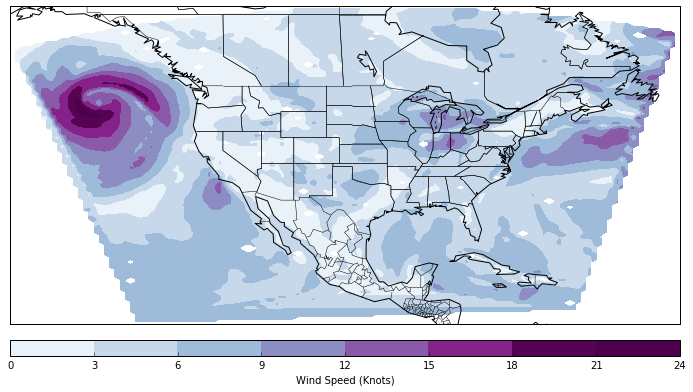

In [43]:
%matplotlib inline
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
from numpy import linspace, transpose
from numpy import meshgrid

plt.figure(figsize=(12, 12), dpi=100)

map = Basemap(projection='cyl',
      resolution = 'c',
      llcrnrlon = lons.min(), llcrnrlat = lats.min(),
      urcrnrlon =lons.max(), urcrnrlat = lats.max()
)
map.drawcoastlines()
map.drawstates()
map.drawcountries()

# 
# We have to reproject our grid, see https://stackoverflow.com/questions/31822553/m
#
x = linspace(0, map.urcrnrx, data.getRawData().shape[1])
y = linspace(0, map.urcrnry, data.getRawData().shape[0])
xx, yy = meshgrid(x, y)
ngrid = len(x)
rlons = np.repeat(np.linspace(np.min(lons), np.max(lons), ngrid),
          ngrid).reshape(ngrid, ngrid)
rlats = np.repeat(np.linspace(np.min(lats), np.max(lats), ngrid),
          ngrid).reshape(ngrid, ngrid).T
tli = mtri.LinearTriInterpolator(mtri.Triangulation(lons.flatten(),
          lats.flatten()), spd.flatten())
rdata = tli(rlons, rlats)
#cs = map.contourf(rlons, rlats, rdata, latlon=True)
cs = map.contourf(rlons, rlats, rdata, latlon=True, vmin=0, vmax=20, cmap='BuPu')

# Add colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")

cbar.set_label("Wind Speed (Knots)")

# Show plot
plt.show()


or use **pcolormesh** rather than **contourf**

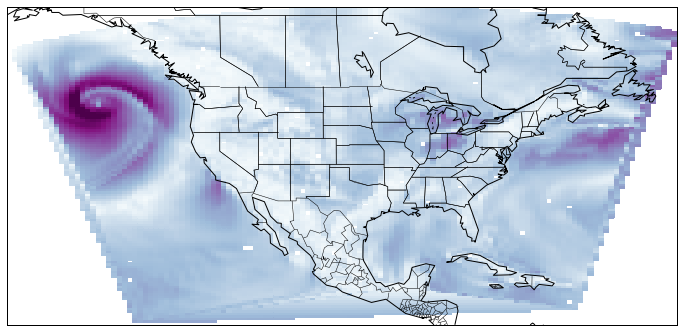

In [44]:
plt.figure(figsize=(12, 12), dpi=100)
map = Basemap(projection='cyl',
      resolution = 'c',
      llcrnrlon = lons.min(), llcrnrlat = lats.min(),
      urcrnrlon =lons.max(), urcrnrlat = lats.max()
)
map.drawcoastlines()
map.drawstates()
map.drawcountries()
cs = map.pcolormesh(rlons, rlats, rdata, latlon=True, vmin=0, vmax=20, cmap='BuPu')


## Plotting a Grid with Cartopy

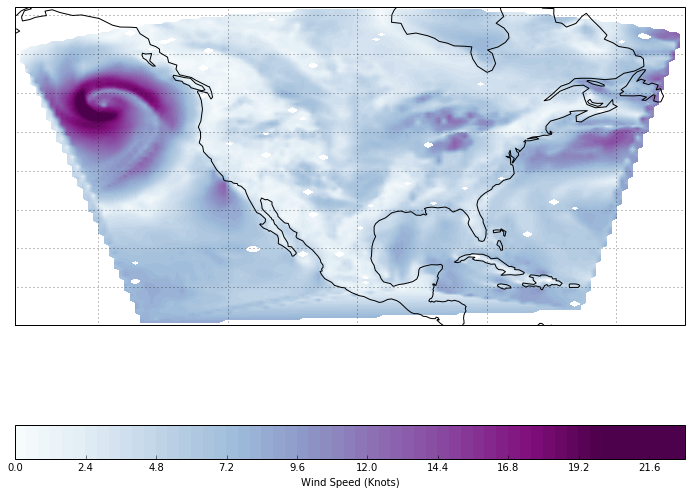

In [45]:
import os
import matplotlib.pyplot as plt
import numpy as np
import iris
import cartopy.crs as ccrs
from cartopy import config

lon,lat = data.getLatLonCoords()
plt.figure(figsize=(12, 12), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(rlons, rlats, rdata, 60, transform=ccrs.PlateCarree(), vmin=0, vmax=20, cmap='BuPu')
ax.coastlines()
ax.gridlines()

# add colorbar
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label("Wind Speed (Knots)")
plt.show()